In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
from matplotlib import pyplot as plt

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# pretrained model
from torchvision import models
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, 10)

# cifar10_resnet18 from 'get_cifar10_model.py'
resnet18.load_state_dict(torch.load('cifar10_resnet18.pt'))

<All keys matched successfully>

In [6]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

valset = datasets.CIFAR10(root='./../data', train=False,
                                        download=True, transform=transform_val)

valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified


In [11]:
# get predictions
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

all_targets = np.array([])
all_predictions = np.array([])
all_probabilities = np.array([])
resnet18 = resnet18.to(device)
resnet18.eval()
for inputs, targets in valloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = resnet18(inputs)
    probabilities = torch.softmax(outputs,dim=1)
    prediction_proba, predictions = probabilities.max(axis=1)
    all_targets = np.r_[all_targets, targets.detach().cpu().numpy()]
    all_predictions = np.r_[all_predictions, predictions.detach().cpu().numpy()]
    all_probabilities = np.r_[all_probabilities, prediction_proba.detach().cpu().numpy()]



In [ ]:
import pandas as pd
is_correct = all_targets == all_predictions
df = pd.DataFrame()
df['probabilities'] = all_probabilities
df['is_correct'] = is_correct
df['prob_bin'] = pd.cut(df.probabilities, bins=[0.1*i for i in range(11)]).map(lambda x: x.left)

In [98]:
# evaluation
from sklearn.metrics import accuracy_score
print('accuracy: ', accuracy_score(all_targets, all_predictions))
print('average confidence: ', all_probabilities.mean())

summary = df.groupby('prob_bin').agg({'probabilities': 'mean', 'is_correct': ['mean','count']})
summary.columns = ['conf_mean', 'accuracy_mean', 'count']
print('ECE: ',((summary['accuracy_mean'] - summary['conf_mean']).abs() * summary['count'] / summary['count'].sum()).sum())

accuracy:  0.8432
average confidence:  0.9142048296138644
ECE:  0.07100482961386448


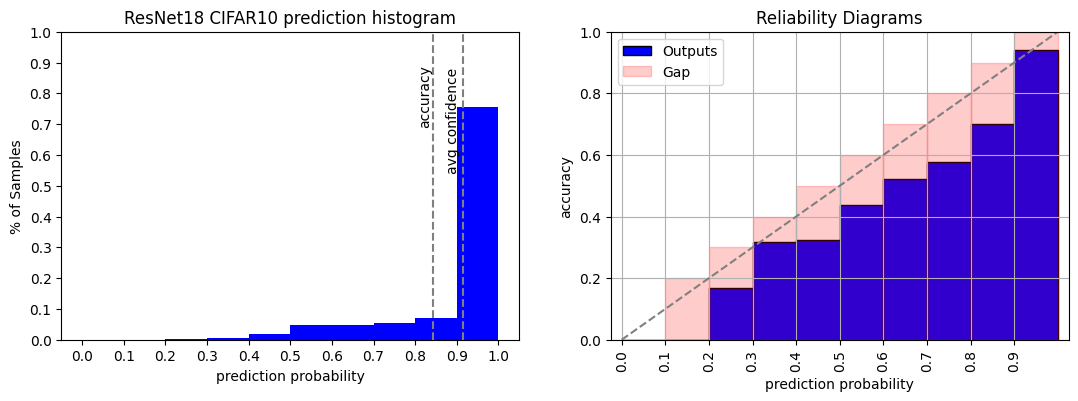

In [86]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.hist(all_probabilities, bins=[0.1*i for i in range(11)], color='blue',density=True)
plt.xticks([0.1*i for i in range(11)], labels=np.round([0.1*i for i in range(11)],1))
plt.yticks([1*i for i in range(11)], labels=np.round([0.1*i for i in range(11)],1))
plt.axvline(x=accuracy_score(all_targets, all_predictions), color='gray', linestyle='--')
plt.text(0.78 ,0.7, 'accuracy', transform=plt.gca().transAxes, rotation=90)
plt.axvline(x=all_probabilities.mean(), color='gray', linestyle='--')
plt.text(0.84, 0.55, 'avg confidence',transform=plt.gca().transAxes, rotation=90)
plt.title('ResNet18 CIFAR10 prediction histogram')
plt.xlabel('prediction probability')
plt.ylabel('% of Samples')


plt.subplot(1,2,2)
df.groupby('prob_bin')['is_correct'].mean().plot(kind='bar',width=1, color='blue', align='edge',edgecolor='black', legend='Outputs')
plt.bar([0,1,2,3,4,5,6,7,8,9],[0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], color='red', alpha=0.2, width=1, align='edge', edgecolor='red')
plt.legend(['Outputs', 'Gap'])
plt.ylim([0,1])
plt.plot([0,10],[0,1], color='gray', linestyle='--')
plt.grid()
plt.title('Reliability Diagrams')
plt.xlabel('prediction probability')
plt.ylabel('accuracy')
plt.show()


# temperature scaling

전체적인 코드는 논문의 github 참고 : https://github.com/gpleiss/temperature_scaling

In [104]:
# code from github of the paper : On Calibration of Modern Neural Networks (2017)
from temperature_scaling import ModelWithTemperature

resnet_with_temperature = ModelWithTemperature(resnet18)
resnet_with_temperature.set_temperature(valloader)
print()

Before temperature - NLL: 0.535, ECE: 0.071
Optimal temperature: 1.571
After temperature - NLL: 0.455, ECE: 0.019



In [107]:
# 그림으로 확인
all_targets = np.array([])
all_predictions = np.array([])
all_probabilities = np.array([])
resnet18 = resnet18.to(device)
resnet18.eval()
for inputs, targets in valloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = resnet18(inputs)
    # temperature 적용
    probabilities = torch.softmax(outputs/resnet_with_temperature.temperature.item(), dim=1)
    prediction_proba, predictions = probabilities.max(axis=1)
    all_targets = np.r_[all_targets, targets.detach().cpu().numpy()]
    all_predictions = np.r_[all_predictions, predictions.detach().cpu().numpy()]
    all_probabilities = np.r_[all_probabilities, prediction_proba.detach().cpu().numpy()]

In [108]:
import pandas as pd
is_correct = all_targets == all_predictions
df = pd.DataFrame()
df['probabilities'] = all_probabilities
df['is_correct'] = is_correct
df['prob_bin'] = pd.cut(df.probabilities, bins=[0.1*i for i in range(11)]).map(lambda x: x.left)

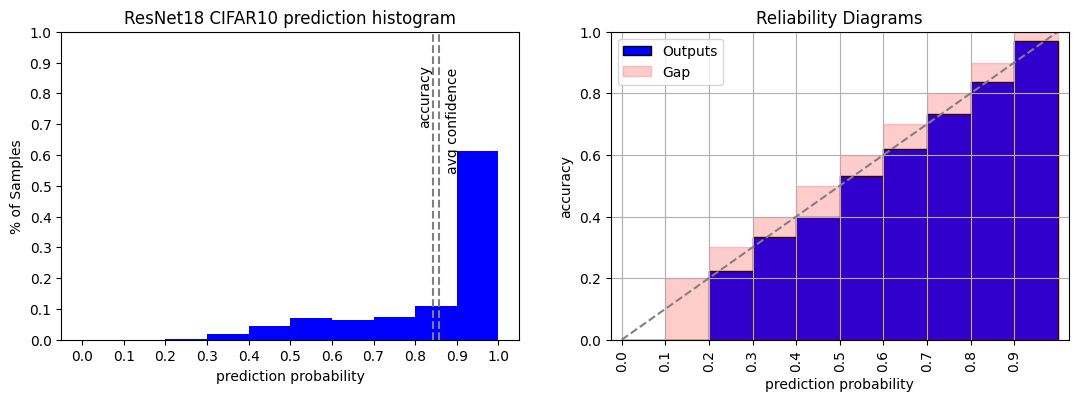

In [109]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.hist(all_probabilities, bins=[0.1*i for i in range(11)], color='blue',density=True)
plt.xticks([0.1*i for i in range(11)], labels=np.round([0.1*i for i in range(11)],1))
plt.yticks([1*i for i in range(11)], labels=np.round([0.1*i for i in range(11)],1))
plt.axvline(x=accuracy_score(all_targets, all_predictions), color='gray', linestyle='--')
plt.text(0.78 ,0.7, 'accuracy', transform=plt.gca().transAxes, rotation=90)
plt.axvline(x=all_probabilities.mean(), color='gray', linestyle='--')
plt.text(0.84, 0.55, 'avg confidence',transform=plt.gca().transAxes, rotation=90)
plt.title('ResNet18 CIFAR10 prediction histogram')
plt.xlabel('prediction probability')
plt.ylabel('% of Samples')


plt.subplot(1,2,2)
df.groupby('prob_bin')['is_correct'].mean().plot(kind='bar',width=1, color='blue', align='edge',edgecolor='black', legend='Outputs')
plt.bar([0,1,2,3,4,5,6,7,8,9],[0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], color='red', alpha=0.2, width=1, align='edge', edgecolor='red')
plt.legend(['Outputs', 'Gap'])
plt.ylim([0,1])
plt.plot([0,10],[0,1], color='gray', linestyle='--')
plt.grid()
plt.title('Reliability Diagrams')
plt.xlabel('prediction probability')
plt.ylabel('accuracy')
plt.show()